# FIT5196 - Assignment 04 - Data Integeration and Reshaping

## Group 025

### Group member 1: Raguram Ramakrishnasamy Dhandapani , Student Number: 30151325
### Group member 2: Thirugnanam Ramanathan, Student Number: 30404975

#### Date: 27-10-2019

#### Version: 3.0
Environment: Python 3 and Jupyter Notebook



## 1. Introduction

- The Assignment focuses on integerating multiple files (in different formats) into a single file
- Then the data is reshaped based on various transformations so that the models built out of it would be more accurate

### Libraries Used

In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#### Loading the data given

In [2]:
property_data = pd.read_csv('Group025.csv')
print(property_data.shape)
property_data.head()

(720, 12)


ID              Address  Rooms Type      Price        Date  \
0  ID646944931       4/16 Repton Rd      2    u   480000.0  22/05/2016   
1  ID954959341      1/11 Rowland St      3    t  1580000.0  16/09/2017   
2  ID134009541           17 Lobb St      4    h  1525000.0   3/06/2017   
3  ID236287948          11 Henry Rd      3    h  1160000.0  24/06/2017   
4  ID733263421  239 Chesterville Rd      3    h   860000.0  22/04/2017   

   Bathroom  Car  Landsize   Age  Lattitude  Longtitude  
0       1.0  1.0       0.0  49.0  -37.88110   145.05240  
1       2.0  2.0    1153.0  16.0  -37.82055   145.11169  
2       2.0  2.0     604.0  49.0  -37.73975   144.96510  
3       1.0  4.0     733.0  39.0  -37.87105   145.23872  
4       1.0  2.0     601.0  49.0  -37.94090   145.06020

#### The data contains duplicate values and is removed

In [3]:
property_data = property_data.drop_duplicates()
property_data.shape

(684, 12)

## TASK 1 - Data Integration
### 1. Shape files

- The shape file data is used to identify the **SUBURB** data of each of the locations
- Based on the shape file provided, a new polygon is built using the points and parts
- Then the polygon is used to calculate the SUBURBs for the provided properties 

In [4]:
### Loading the Shapefile library and rading the SHAPE FILE
#!pip install pyshp
import shapefile

shp = shapefile.Reader("supplementary_data/VIC_LOCALITY_POLYGON_shp.shp")
print(shp)

shapefile Reader
    2973 shapes (type 'POLYGON')
    2973 records (13 fields)


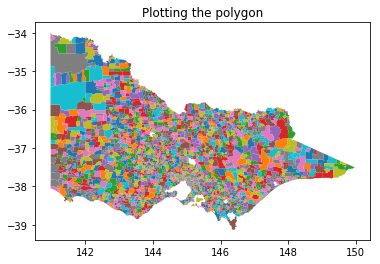

In [5]:

#Plottign the points to have an idea of the shape
for shape in shp.shapeRecords():
    if len(shape.shape.parts) == 1:
        x = [i[0] for i in shape.shape.points]             
        y = [i[1] for i in shape.shape.points]
        
        plt.fill(x, y)
        plt.title('Plotting the polygon')

In [6]:

## Setting up a polygon for SUBURB classification
from matplotlib.patches import Polygon

shapes = shp.shapes()
records = shp.records()

polygon_struct   = []
suburbs_list = []

#Looping through the shapes and creating a polygon based on points
for x in range(len(shp.shapes())):
    points     = np.array(shapes[x].points)
    parts      = shapes[x].parts
    main_part  = list(parts) + [points.shape[0]]
    
    for pij in range(len(parts)):
        polygon_struct.append(Polygon(points[main_part[pij]:main_part[pij+1]]))
        suburbs_list.append(records[x][6])


In [7]:

#Identifying the Suburbs for each of the property
suburb_dict = {}
for index,row in property_data.iterrows():
    (lat,lon) = (row['Lattitude'],row['Longtitude'])
    for i in range(len(polygon_struct)):
        if polygon_struct[i].contains_point((lon,lat)):
            suburb_dict[row['ID']] = suburbs_list[i]
            break;


In [8]:
#Mapping the data as a dataframe and appending the data to the main dataframe
suburb_df = pd.DataFrame(list(suburb_dict.items()),index=None,columns=['ID','Suburb'])
suburb_df.head()

ID          Suburb
0  ID646944931    MALVERN EAST
1  ID954959341     MONT ALBERT
2  ID134009541          COBURG
3  ID236287948  WANTIRNA SOUTH
4  ID733263421       MOORABBIN

In [9]:
property_data = pd.merge(property_data,suburb_df,how='left')
property_data.head()

ID              Address  Rooms Type      Price        Date  \
0  ID646944931       4/16 Repton Rd      2    u   480000.0  22/05/2016   
1  ID954959341      1/11 Rowland St      3    t  1580000.0  16/09/2017   
2  ID134009541           17 Lobb St      4    h  1525000.0   3/06/2017   
3  ID236287948          11 Henry Rd      3    h  1160000.0  24/06/2017   
4  ID733263421  239 Chesterville Rd      3    h   860000.0  22/04/2017   

   Bathroom  Car  Landsize   Age  Lattitude  Longtitude          Suburb  
0       1.0  1.0       0.0  49.0  -37.88110   145.05240    MALVERN EAST  
1       2.0  2.0    1153.0  16.0  -37.82055   145.11169     MONT ALBERT  
2       2.0  2.0     604.0  49.0  -37.73975   144.96510          COBURG  
3       1.0  4.0     733.0  39.0  -37.87105   145.23872  WANTIRNA SOUTH  
4       1.0  2.0     601.0  49.0  -37.94090   145.06020       MOORABBIN

### 2. Crime data file

- For each of the Suburbs and broder areas, as given in the council file and the crime data files, the type of crimes for each of the suburbs are calculated
- Type A, Type B, Type C are the crimes that are identified for past 3 years of a property SUBURB and the average crime of each type is calculated

In [10]:
#Loading the crime data file
crime = pd.read_excel('supplementary_data/crimebylocationdatatable-yearending31march2016.xlsx',sheet_name='Table 1',skiprows=19)
crime = crime.iloc[:,1:]
crime.head()

Apr - Mar reference period       Police Region Police Service Area  \
0                        2012  1 North West Metro             BANYULE   
1                        2012  1 North West Metro             BANYULE   
2                        2012  1 North West Metro             BANYULE   
3                        2012  1 North West Metro             BANYULE   
4                        2012  1 North West Metro             BANYULE   

  Local Government Area         CSA Offence Division  \
0               BANYULE  A Crimes against the person   
1               BANYULE  A Crimes against the person   
2               BANYULE  A Crimes against the person   
3               BANYULE  A Crimes against the person   
4               BANYULE  A Crimes against the person   

              CSA Offence Subdivision  Offence Count  LGA ERP  Victorian ERP  
0   A10 Homicide and related offences              4   123600        5632521  
1    A20 Assault and related offences            568   123600        5632521  
2                 A30 Sexual offences            132   123600        5632521  
3  A40 Abduction and related offences             12   123600        5632521  
4                         A50 Robbery             46   123600        5632521

#### Splitting the type of Crime based on the CSA Offences division

In [11]:

crime['Offence_type'] = crime['CSA Offence Division'].str[0]
req_offence_type_df = ('A','B','C')
crime.head(100)

Apr - Mar reference period       Police Region Police Service Area  \
0                         2012  1 North West Metro             BANYULE   
1                         2012  1 North West Metro             BANYULE   
2                         2012  1 North West Metro             BANYULE   
3                         2012  1 North West Metro             BANYULE   
4                         2012  1 North West Metro             BANYULE   
5                         2012  1 North West Metro             BANYULE   
6                         2012  1 North West Metro             BANYULE   
7                         2012  1 North West Metro             BANYULE   
8                         2012  1 North West Metro             BANYULE   
9                         2012  1 North West Metro             BANYULE   
10                        2012  1 North West Metro             BANYULE   
11                        2012  1 North West Metro             BANYULE   
12                        2012  1 North West Metro             BANYULE   
13                        2012  1 North West Metro             BANYULE   
14                        2012  1 North West Metro             BANYULE   
15                        2012  1 North West Metro             BANYULE   
16                        2012  1 North West Metro             BANYULE   
17                        2012  1 North West Metro             BANYULE   
18                        2012  1 North West Metro             BANYULE   
19                        2012  1 North West Metro             BANYULE   
20                        2012  1 North West Metro             BANYULE   
21                        2012  1 North West Metro             BANYULE   
22                        2012  1 North West Metro             BANYULE   
23                        2012  1 North West Metro             BANYULE   
24                        2012  1 North West Metro             BANYULE   
25                        2012  1 North West Metro             BANYULE   
26                        2012  1 North West Metro            BRIMBANK   
27                        2012  1 North West Metro            BRIMBANK   
28                        2012  1 North West Metro            BRIMBANK   
29                        2012  1 North West Metro            BRIMBANK   
..                         ...                 ...                 ...   
70                        2012  1 North West Metro             DAREBIN   
71                        2012  1 North West Metro             DAREBIN   
72                        2012  1 North West Metro             DAREBIN   
73                        2012  1 North West Metro             DAREBIN   
74                        2012  1 North West Metro             DAREBIN   
75                        2012  1 North West Metro             DAREBIN   
76                        2012  1 North West Metro             DAREBIN   
77                        2012  1 North West Metro         HOBSONS BAY   
78                        2012  1 North West Metro         HOBSONS BAY   
79                        2012  1 North West Metro         HOBSONS BAY   
80                        2012  1 North West Metro         HOBSONS BAY   
81                        2012  1 North West Metro         HOBSONS BAY   
82                        2012  1 North West Metro         HOBSONS BAY   
83                        2012  1 North West Metro         HOBSONS BAY   
84                        2012  1 North West Metro         HOBSONS BAY   
85                        2012  1 North West Metro         HOBSONS BAY   
86                        2012  1 North West Metro         HOBSONS BAY   
87                        2012  1 North West Metro         HOBSONS BAY   
88                        2012  1 North West Metro         HOBSONS BAY   
89                        2012  1 North West Metro         HOBSONS BAY   
90                        2012  1 North West Metro         HOBSONS BAY   
91                        2012  1 North West Metro         HOBSONS BAY   
92      

In [12]:
## Crime data is grouped and filtered based on different factors
crime_off_type = crime.loc[crime['Offence_type'].isin(req_offence_type_df)]
crime_off_type.tail(100)
final_crime = crime_off_type.groupby(['Apr - Mar reference period','Local Government Area','Offence_type']).agg({'Offence Count': 'sum'})

final_crime = final_crime.reset_index()

#the final four columns needed for the analysis
final_crime.columns = ['Year', 'Local Government Area', 'Offence_type', 'Offence Count']
final_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Data columns (total 4 columns):
Year                     1184 non-null int64
Local Government Area    1184 non-null object
Offence_type             1184 non-null object
Offence Count            1184 non-null int64
dtypes: int64(2), object(2)
memory usage: 37.1+ KB


#### From the councils file, each suburb and its local government area are split
- The data split is stored in the dictionary and used in the further analysis

In [13]:
##Loading data from councils file
councils = open("supplementary_data/councils.txt", "r")
line = councils.readline()
sub_lga_final_dict ={}
while line:
    lga = line.split(':')[0]
    suburbs_lga = line.split(':')[1]
    
    sub_lga = suburbs_lga.split(',')
    for item in sub_lga:
        
        cleanString = re.sub('\W+','', item )
        cleanString = cleanString.upper()
       
        sub_lga_final_dict[cleanString] = lga
    line = councils.readline()
councils.close()

sub_lga_final_dict

{'ABBOTSFORD': 'BANYULE ',
 'AIRPORTWEST': 'BANYULE ',
 'ALBERTPARK': 'BANYULE ',
 'ALPHINGTON': 'BANYULE ',
 'ALTONA': 'BRIMBANK ',
 'ALTONANORTH': 'BRIMBANK ',
 'ARMADALE': 'BRIMBANK ',
 'ASCOTVALE': 'BRIMBANK ',
 'ASHBURTON': 'DAREBIN ',
 'ASHWOOD': 'DAREBIN ',
 'AVONDALEHEIGHTS': 'DAREBIN ',
 'BALACLAVA': 'DAREBIN ',
 'BALWYN': 'HOBSONS BAY ',
 'BALWYNNORTH': 'HOBSONS BAY ',
 'BENTLEIGH': 'HOBSONS BAY ',
 'BENTLEIGHEAST': 'HOBSONS BAY ',
 'BOXHILL': 'HUME ',
 'BRAYBROOK': 'HUME ',
 'BRIGHTON': 'HUME ',
 'BRIGHTONEAST': 'HUME ',
 'BRUNSWICK': 'MARIBYRNONG ',
 'BRUNSWICKWEST': 'MARIBYRNONG ',
 'BULLEEN': 'MARIBYRNONG ',
 'BURWOOD': 'MARIBYRNONG ',
 'CAMBERWELL': 'MELBOURNE ',
 'CANTERBURY': 'MELBOURNE ',
 'CARLTONNORTH': 'MELBOURNE ',
 'CARNEGIE': 'MELBOURNE ',
 'CAULFIELD': 'MELTON ',
 'CAULFIELDNORTH': 'MELTON ',
 'CAULFIELDSOUTH': 'MELTON ',
 'CHADSTONE': 'MELTON ',
 'CLIFTONHILL': 'MOONEE VALLEY ',
 'COBURG': 'MOONEE VALLEY ',
 'COBURGNORTH': 'MOONEE VALLEY ',
 'COLLINGWOOD': 'MO

#### The crimes for each proeprty and its suburb is calculated

In [14]:
ID = []
crime_A_avg = []
crime_B_avg = []
crime_C_avg = []
property_data['Date'] = pd.to_datetime(property_data['Date'])
property_data['year'] = property_data['Date'].apply(lambda x: x.year)
property_data['suburb_for_lga'] = property_data['Suburb'].apply(lambda x: re.sub('\W+','', x))
property_data.head()

for index,row in property_data.iterrows():

    three_year_before = row['year'] - 3
    two_year_before = row['year'] - 2
    prev_year = row['year'] - 1
    lga = sub_lga_final_dict[row['suburb_for_lga']]
    lga = lga.strip()
    
    years_list=(three_year_before,two_year_before,prev_year)
    
    filtered_df_A = final_crime.loc[(final_crime['Year'].isin(years_list))&(final_crime['Local Government Area']==lga)&(final_crime['Offence_type']=='A')]
    filtered_df_B = final_crime.loc[(final_crime['Year'].isin(years_list))&(final_crime['Local Government Area']==lga)&(final_crime['Offence_type']=='B')]
    filtered_df_C = final_crime.loc[(final_crime['Year'].isin(years_list))&(final_crime['Local Government Area']==lga)&(final_crime['Offence_type']=='C')]
    
    ID.append(row['ID'])
    
    crime_A_avg.append(int(filtered_df_A['Offence Count'].mean()))
    crime_B_avg.append(int(filtered_df_B['Offence Count'].mean()))
    crime_C_avg.append(int(filtered_df_C['Offence Count'].mean()))

crime_avg_df = pd.DataFrame(
    {'ID': ID,
     'crime_A_avg': crime_A_avg,
     'crime_B_avg': crime_B_avg,
     'crime_C_avg': crime_C_avg
    })
crime_avg_df.head()

ID  crime_A_avg  crime_B_avg  crime_C_avg
0  ID646944931          610         1743          228
1  ID954959341          313          545           65
2  ID134009541         1097         5916          553
3  ID236287948           98          190           19
4  ID733263421           84          293           23

In [15]:
##Adding the crime data to the main dataset
property_data = property_data.drop(columns=['year', 'suburb_for_lga'])
property_data = pd.merge(property_data,crime_avg_df,how='left')
property_data.head()

ID              Address  Rooms Type      Price       Date  \
0  ID646944931       4/16 Repton Rd      2    u   480000.0 2016-05-22   
1  ID954959341      1/11 Rowland St      3    t  1580000.0 2017-09-16   
2  ID134009541           17 Lobb St      4    h  1525000.0 2017-03-06   
3  ID236287948          11 Henry Rd      3    h  1160000.0 2017-06-24   
4  ID733263421  239 Chesterville Rd      3    h   860000.0 2017-04-22   

   Bathroom  Car  Landsize   Age  Lattitude  Longtitude          Suburb  \
0       1.0  1.0       0.0  49.0  -37.88110   145.05240    MALVERN EAST   
1       2.0  2.0    1153.0  16.0  -37.82055   145.11169     MONT ALBERT   
2       2.0  2.0     604.0  49.0  -37.73975   144.96510          COBURG   
3       1.0  4.0     733.0  39.0  -37.87105   145.23872  WANTIRNA SOUTH   
4       1.0  2.0     601.0  49.0  -37.94090   145.06020       MOORABBIN   

   crime_A_avg  crime_B_avg  crime_C_avg  
0          610         1743          228  
1          313          545           65  
2         1097         5916          553  
3           98          190           19  
4           84          293           23

###  3. Train Station Data
- The train data is fetched from the GTFS datasets
- Only the train data is considered and is stored in two folders (1,2)
- From these two folders, the files of Stop_times, stops, routes, calendar are used for this Data Integeration process

#### Folder 1 analysis

In [16]:
#Folder 1 data read
train_data_1_stop_times = pd.read_csv('supplementary_data/1/stop_times.txt').iloc[:,:5]
train_data_1_stops_details = pd.read_csv('supplementary_data/1/stops.txt')

In [17]:
#Southern Cross Railway Station - getting the code for it
for index,row in train_data_1_stops_details.iterrows():
    if 'Southern Cross Railway Station' in str(row['stop_name']):
        main_id = row['stop_id']
        break;
main_id

20043

In [18]:
#Combining the tow datasets
train_data_1_stops_1 = pd.merge(train_data_1_stop_times,train_data_1_stops_details,how = 'left',on='stop_id')
train_data_1_stops_1.head()

trip_id arrival_time departure_time  stop_id  \
0  7548.UR.1-V08-A-mjp-1.1.H     06:08:00       06:08:00    20291   
1  7548.UR.1-V08-A-mjp-1.1.H     06:42:00       06:42:00    20346   
2  7548.UR.1-V08-A-mjp-1.1.H     06:55:00       06:57:00    20341   
3  7548.UR.1-V08-A-mjp-1.1.H     07:16:00       07:16:00    20339   
4  7548.UR.1-V08-A-mjp-1.1.H     07:32:00       07:34:00    20351   

   stop_sequence                                stop_name   stop_lat  \
0              1  Bairnsdale Railway Station (Bairnsdale) -37.828720   
1              2    Stratford Railway Station (Stratford) -37.967047   
2              3              Sale Railway Station (Sale) -38.103103   
3              4      Rosedale Railway Station (Rosedale) -38.156404   
4              5    Traralgon Railway Station (Traralgon) -38.198885   

     stop_lon  
0  147.627614  
1  147.081469  
2  147.054805  
3  146.786966  
4  146.537882

In [19]:
### Function to calculate the distance between two points
from math import sin, cos, sqrt, atan2,radians

def calc_length(lat1,lon1,lat2,lon2):
    R = 6378.0

    dlat = radians(float(lat2)-float(lat1))
    dlon = radians(float(lon2)-float(lon1))
    a = abs(sin(dlat / 2)**2 + cos(float(lat1)) * cos(float(lat2)) * sin(dlon / 2)**2)
    #print(a)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

#### Identiying the closest station and its distance

In [20]:
###  This loop finds out the closest station and its distance from the property

trip_list=[]
stop_list = {}
dist_list = {}

for index, row1 in property_data.iterrows():
    
    dist_dict = {}
    
    #Calculating the distance between the PROPERTY and stations
    
    for index, row2 in train_data_1_stops_details.iterrows():
        dist_dict[row2['stop_id']] = calc_length(row1['Lattitude'],row1['Longtitude'],row2['stop_lat'],row2['stop_lon'])
    
    #Sorting the dictionary in the order of the values
    sort_dict = sorted(dist_dict.items(), key=lambda x: x[1])
    
    #Starting with the nearest station, the trips are calculated
    #When the first station with Southern cross is identified, we exit this loop
    for item in sort_dict:
        stp_id = item[0]
                
        if stp_id==main_id:
            stop_list[row1['ID']]=stp_id
            dist_list[row1['ID']]=item[1]
            break;
        else: 
            #Subset of main dataset for that Station ID to filter all trips for that station
            list_tripIDs = train_data_1_stops_1[train_data_1_stops_1['stop_id']==stp_id]['trip_id'].drop_duplicates()

            #All trips from that station are considered
            for trip in list_tripIDs:
                new_set = train_data_1_stops_1[train_data_1_stops_1['trip_id']==trip]
                trip_dict = {}

                #If the trips are in the required time frame then it would be checked, else it would be ignored
                #If southern cross station is in that sequence then sequence number is checked 
                found = new_set[new_set['stop_id'].astype(str).str.contains(str(main_id))]
                
                if len(found)>0:                    
                    trip_dict = dict(zip(new_set['stop_id'],new_set['stop_sequence']))
                    stpID_seq = trip_dict[stp_id]
                    soucr_seq = trip_dict[main_id]

                    #If the seq no are matching correctly (station < southern cross), that trip is included in the analysis\
                    if stpID_seq < soucr_seq:
                        stop_list[row1['ID']]=stp_id
                        dist_list[row1['ID']]=item[1] 
                        break
                    else:
                        continue
        
        #If a station has been found the loop for this property is exited   
        if row1['ID'] in stop_list.keys():
            break
        else:
            continue
                  

In [21]:
#Transfering the data to DF
Stop_ID_DF = pd.DataFrame(list(stop_list.items()), columns = ['ID','Stop_ID_1'])
dist_ID_DF = pd.DataFrame(list(dist_list.items()), columns = ['ID','Distance_1'])

In [22]:
new_DF = pd.merge(Stop_ID_DF,dist_ID_DF,how='left')
Inter_DF = pd.merge(property_data,new_DF,how='left' )
Inter_DF.head()

ID              Address  Rooms Type      Price       Date  \
0  ID646944931       4/16 Repton Rd      2    u   480000.0 2016-05-22   
1  ID954959341      1/11 Rowland St      3    t  1580000.0 2017-09-16   
2  ID134009541           17 Lobb St      4    h  1525000.0 2017-03-06   
3  ID236287948          11 Henry Rd      3    h  1160000.0 2017-06-24   
4  ID733263421  239 Chesterville Rd      3    h   860000.0 2017-04-22   

   Bathroom  Car  Landsize   Age  Lattitude  Longtitude          Suburb  \
0       1.0  1.0       0.0  49.0  -37.88110   145.05240    MALVERN EAST   
1       2.0  2.0    1153.0  16.0  -37.82055   145.11169     MONT ALBERT   
2       2.0  2.0     604.0  49.0  -37.73975   144.96510          COBURG   
3       1.0  4.0     733.0  39.0  -37.87105   145.23872  WANTIRNA SOUTH   
4       1.0  2.0     601.0  49.0  -37.94090   145.06020       MOORABBIN   

   crime_A_avg  crime_B_avg  crime_C_avg  Stop_ID_1  Distance_1  
0          610         1743          228      22248    1.154921  
1          313          545           65      22248    9.901569  
2         1097         5916          553      22253    5.730459  
3           98          190           19      22250   13.603922  
4           84          293           23      22249    6.778301

#### Folder - 2
- The same steps as above is done and this is stored as Stop_ID_2 for the property

In [23]:
#Reading the data
train_data_2_stop_times = pd.read_csv('supplementary_data/2/stop_times.txt').iloc[:,:5]
train_data_2_stops_details = pd.read_csv('supplementary_data/2/stops.txt')

In [24]:
#Southern Cross Railway Station - ID in Folder 2
for index,row in train_data_2_stops_details.iterrows():
    if 'Southern Cross Railway Station' in str(row['stop_name']):
        main_id_2 = row['stop_id']
        break;
main_id_2

22180

#### Filtering the content in the stop times based on time with some buffer
- Since the file size is huge considering all the trips is not needed since we are considering only the trips from 7 to 9:30 AM
-  We keep a buffer of 2 hours so that we will be able to identify the trips corretly

In [25]:
## Departure time from 7 - 11:00 AM
list1 = []
for index,row in train_data_2_stop_times.iterrows():
    if re.match('2[4567]:.*:.*',str(row['departure_time'])):
        list1.append(1)
    elif (datetime.strptime(row['departure_time'], "%H:%M:%S")>=datetime.strptime('07:00:00',"%H:%M:%S") and datetime.strptime(row['departure_time'], "%H:%M:%S")<=datetime.strptime('11:00:00',"%H:%M:%S")):
        list1.append(0)
    else:
        list1.append(1)
        
train_data_2_stop_times['row_del'] = list1
train_data_2_stop_times = train_data_2_stop_times[train_data_2_stop_times['row_del']==0]
train_data_2_stop_times.shape

(107195, 6)

In [26]:
##Combinig the files
train_data_2_stops_1 = pd.merge(train_data_2_stop_times,train_data_2_stops_details,how = 'left',on='stop_id')
print(train_data_2_stops_1.shape)
train_data_2_stops_1.head()

(107195, 9)


trip_id arrival_time departure_time  stop_id  \
0  9125.T5.2-ALM-A-mjp-1.1.H     09:21:00       09:21:00    19853   
1  9125.T5.2-ALM-A-mjp-1.1.H     09:24:00       09:24:00    19852   
2  9125.T5.2-ALM-A-mjp-1.1.H     09:25:00       09:25:00    19851   
3  9125.T5.2-ALM-A-mjp-1.1.H     09:27:00       09:27:00    19850   
4  9125.T5.2-ALM-A-mjp-1.1.H     09:28:00       09:28:00    19849   

   stop_sequence  row_del                                stop_name   stop_lat  \
0              1        0  Camberwell Railway Station (Camberwell) -37.826567   
1              2        0  Riversdale Railway Station (Camberwell) -37.831505   
2              3        0    Willison Railway Station (Camberwell) -37.835716   
3              4        0    Hartwell Railway Station (Camberwell) -37.843985   
4              5        0      Burwood Railway Station (Glen Iris) -37.851563   

     stop_lon  
0  145.058697  
1  145.069646  
2  145.070298  
3  145.075560  
4  145.080511

In [27]:
### Main Loop -  the same loop as above but for the second folder
stop_list = {}
dist_list = {}

for index, row1 in property_data.iterrows():
    
    dist_dict = {}
    
    #Calculating the distance between the PROPERTY and stations
    
    for index, row2 in train_data_2_stops_details.iterrows():
        dist_dict[row2['stop_id']] = calc_length(row1['Lattitude'],row1['Longtitude'],row2['stop_lat'],row2['stop_lon'])
    
    #Sorting the dictionary in the order of the values
    sort_dict = sorted(dist_dict.items(), key=lambda x: x[1])
    
    #Starting with the nearest station, the trips are calculated
    #When the first station with Southern cross is identified, we exit this loop
    for item in sort_dict:
        stp_id = item[0]
       
        if stp_id==main_id_2:
            stop_list[row1['ID']]=stp_id
            dist_list[row1['ID']]=item[1]
            break;
        else: 
            #Subset of main dataset for that Station ID to filter all trips for that station
            list_tripIDs = train_data_2_stops_1[train_data_2_stops_1['stop_id']==stp_id]['trip_id'].drop_duplicates()

            #All trips from that station are considered
            for trip in list_tripIDs:
                new_set = train_data_2_stops_1[train_data_2_stops_1['trip_id']==trip]

                #If the trips are in the required time frame then it would be checked, else it would be ignored
                #If southern cross station is in that sequence then sequence number is checked 
                found = new_set[new_set['stop_id'].astype(str).str.contains(str(main_id_2))]
                
                if len(found)>0: 
                    trip_dict = dict(zip(new_set['stop_id'],new_set['stop_sequence']))
                    stpID_seq = trip_dict[stp_id]
                    soucr_seq = trip_dict[main_id_2]
                    
                    #If the seq no are matching correctly (station < southern cross), that trip is included in the analysis\
                    if stpID_seq < soucr_seq:                        
                        stop_list[row1['ID']]=stp_id
                        dist_list[row1['ID']]=item[1] 
                        break                    
                    else:
                        continue
                        
        if row1['ID'] in stop_list.keys():
            break
        else:
            continue

In [28]:
#Storing the data into the dataframe
Stop_ID_DF = pd.DataFrame(list(stop_list.items()), columns = ['ID','Stop_ID_2'])
dist_ID_DF = pd.DataFrame(list(dist_list.items()), columns = ['ID','Distance_2'])
new_DF_2 = pd.merge(Stop_ID_DF,dist_ID_DF,how='left')
Inter_DF_2 = pd.merge(Inter_DF,new_DF_2,how='left' )

In [29]:
#Combing all the dataframes together
Inter_DF_3 = pd.merge(Inter_DF_2,train_data_1_stops_details,how='left', left_on='Stop_ID_1', right_on='stop_id')
Inter_DF_3 = Inter_DF_3.rename(columns={'stop_name':'stop_name_1','stop_lat':'stop_lat_1','stop_lon':'stop_lon_1'}).drop(columns=('stop_id'))
Inter_DF_3.head(5)

ID              Address  Rooms Type      Price       Date  \
0  ID646944931       4/16 Repton Rd      2    u   480000.0 2016-05-22   
1  ID954959341      1/11 Rowland St      3    t  1580000.0 2017-09-16   
2  ID134009541           17 Lobb St      4    h  1525000.0 2017-03-06   
3  ID236287948          11 Henry Rd      3    h  1160000.0 2017-06-24   
4  ID733263421  239 Chesterville Rd      3    h   860000.0 2017-04-22   

   Bathroom  Car  Landsize   Age     ...      crime_A_avg  crime_B_avg  \
0       1.0  1.0       0.0  49.0     ...              610         1743   
1       2.0  2.0    1153.0  16.0     ...              313          545   
2       2.0  2.0     604.0  49.0     ...             1097         5916   
3       1.0  4.0     733.0  39.0     ...               98          190   
4       1.0  2.0     601.0  49.0     ...               84          293   

  crime_C_avg  Stop_ID_1  Distance_1  Stop_ID_2  Distance_2  \
0         228      22248    1.154921      19920    0.885526   
1          65      22248    9.901569      19896    0.692062   
2         553      22253    5.730459      19965    0.349173   
3          19      22250   13.603922      19870    4.594537   
4          23      22249    6.778301      19872    2.149006   

                                  stop_name_1  stop_lat_1  stop_lon_1  
0  Caulfield Railway Station (Caulfield East)  -37.877459  145.042525  
1  Caulfield Railway Station (Caulfield East)  -37.877459  145.042525  
2         Essendon Railway Station (Essendon)  -37.756012  144.916198  
3       Dandenong Railway Station (Dandenong)  -37.989968  145.209725  
4           Clayton Railway Station (Clayton)  -37.924683  145.120534  

[5 rows x 23 columns]

In [30]:
Inter_DF_4 = pd.merge(Inter_DF_3,train_data_2_stops_details,how='left', left_on='Stop_ID_2', right_on='stop_id',)
Inter_DF_4 = Inter_DF_4.rename(columns={'stop_name':'stop_name_2','stop_lat':'stop_lat_2','stop_lon':'stop_lon_2'})
Inter_DF_4.head(5)

ID              Address  Rooms Type      Price       Date  \
0  ID646944931       4/16 Repton Rd      2    u   480000.0 2016-05-22   
1  ID954959341      1/11 Rowland St      3    t  1580000.0 2017-09-16   
2  ID134009541           17 Lobb St      4    h  1525000.0 2017-03-06   
3  ID236287948          11 Henry Rd      3    h  1160000.0 2017-06-24   
4  ID733263421  239 Chesterville Rd      3    h   860000.0 2017-04-22   

   Bathroom  Car  Landsize   Age     ...      Distance_1  Stop_ID_2  \
0       1.0  1.0       0.0  49.0     ...        1.154921      19920   
1       2.0  2.0    1153.0  16.0     ...        9.901569      19896   
2       2.0  2.0     604.0  49.0     ...        5.730459      19965   
3       1.0  4.0     733.0  39.0     ...       13.603922      19870   
4       1.0  2.0     601.0  49.0     ...        6.778301      19872   

  Distance_2                                 stop_name_1  stop_lat_1  \
0   0.885526  Caulfield Railway Station (Caulfield East)  -37.877459   
1   0.692062  Caulfield Railway Station (Caulfield East)  -37.877459   
2   0.349173         Essendon Railway Station (Essendon)  -37.756012   
3   4.594537       Dandenong Railway Station (Dandenong)  -37.989968   
4   2.149006           Clayton Railway Station (Clayton)  -37.924683   

   stop_lon_1  stop_id                                stop_name_2  stop_lat_2  \
0  145.042525    19920        Carnegie Railway Station (Carnegie)  -37.886241   
1  145.042525    19896  Mont Albert Railway Station (Mont Albert)  -37.819427   
2  144.916198    19965            Coburg Railway Station (Coburg)  -37.742345   
3  145.209725    19870      Bayswater Railway Station (Bayswater)  -37.841730   
4  145.120534    19872          Highett Railway Station (Highett)  -37.948425   

   stop_lon_2  
0  145.058575  
1  145.105530  
2  144.963336  
3  145.268136  
4  145.041872  

[5 rows x 27 columns]

#### Finding the Station_ID, Distance and Average travel time

In [31]:
#Using the trips and calendar to find out the trains operating on weekdays
train_data_1_trips = pd.read_csv('supplementary_data/1/trips.txt').iloc[:,:3]
train_data_1_calendar = pd.read_csv('supplementary_data/1/calendar.txt')
train_data_1_stops_2 = pd.merge(train_data_1_trips,train_data_1_calendar,how = 'left')
train_data_1_stops_2.head()

route_id service_id                    trip_id  monday  tuesday  \
0  1-V08-G-mjp-1         T0  1051.T0.1-V08-G-mjp-1.1.H       1        1   
1  1-V08-G-mjp-1         T0  1052.T0.1-V08-G-mjp-1.2.H       1        1   
2  1-V08-G-mjp-1         T0  1053.T0.1-V08-G-mjp-1.2.H       1        1   
3  1-V08-G-mjp-1         T0  1522.T0.1-V08-G-mjp-1.4.R       1        1   
4  1-V08-G-mjp-1         T0  1523.T0.1-V08-G-mjp-1.5.R       1        1   

   wednesday  thursday  friday  saturday  sunday  start_date  end_date  
0          1         1       1         0       0    20190515  20190523  
1          1         1       1         0       0    20190515  20190523  
2          1         1       1         0       0    20190515  20190523  
3          1         1       1         0       0    20190515  20190523  
4          1         1       1         0       0    20190515  20190523

In [32]:
## Dropping rows that have no trips on weekdays
del_row = []
for index, row in train_data_1_stops_2.iterrows():
    if row['monday']==0 and row['tuesday']==0 and row['wednesday']==0 and row['thursday']==0 and row['friday']==0:
        del_row.append(1)
    else:
        del_row.append(0)
        
train_data_1_stops_2['del_row'] = del_row
train_data_1_stops_2 = train_data_1_stops_2[train_data_1_stops_2['del_row']==1]
train_data_1_stops_2.shape

(2169, 13)

In [33]:
#Loading the data for folder 2
train_data_2_trips = pd.read_csv('supplementary_data/2/trips.txt').iloc[:,:3]
train_data_2_calendar = pd.read_csv('supplementary_data/2/calendar.txt')
train_data_2_stops_2 = pd.merge(train_data_2_trips,train_data_2_calendar,how = 'left')
train_data_2_stops_2.head()

route_id service_id                    trip_id  monday  tuesday  \
0  2-ALM-F-mjp-1         T0  8262.T0.2-ALM-F-mjp-1.1.H       1        1   
1  2-ALM-F-mjp-1         T0  8267.T0.2-ALM-F-mjp-1.1.H       1        1   
2  2-ALM-F-mjp-1         T0  8271.T0.2-ALM-F-mjp-1.1.H       1        1   
3  2-ALM-F-mjp-1         T0  8274.T0.2-ALM-F-mjp-1.1.H       1        1   
4  2-ALM-F-mjp-1         T0  8278.T0.2-ALM-F-mjp-1.1.H       1        1   

   wednesday  thursday  friday  saturday  sunday  start_date  end_date  
0          1         1       1         0       0    20190524  20190810  
1          1         1       1         0       0    20190524  20190810  
2          1         1       1         0       0    20190524  20190810  
3          1         1       1         0       0    20190524  20190810  
4          1         1       1         0       0    20190524  20190810

In [34]:
## Dropping rows that have no trips on weekdays
del_row = []
for index, row in train_data_2_stops_2.iterrows():
    if row['monday']==0 and row['tuesday']==0 and row['wednesday']==0 and row['thursday']==0 and row['friday']==0:
        del_row.append(1)
    else:
        del_row.append(0)
        
train_data_2_stops_2['del_row'] = del_row
train_data_2_stops_2 = train_data_2_stops_2[train_data_2_stops_2['del_row']==1]
train_data_2_stops_2.shape

(11238, 13)

#### Defining a function that calculates the average time to cbd column
-  Various conditions are considered here
- They are Weekday trips, direct trip to Southern cross, departure time between 7 to 9:30AM

In [35]:

def average_time(df,df2, name, southID ):
    transit_time = []
    
    found_1 = df[df['stop_name']==str(name)]
    #IF that railways station is present in that Datafame
    
    if len(found_1) > 0: 
         
        #Getting all the trip IDs and the stop ID for that stop
        tripIDs = df[df['stop_name']==name]['trip_id'].drop_duplicates()
        stp_id = list(df[df['stop_name']==name]['stop_id'].drop_duplicates())[0]
        
        if stp_id == southID:
            return 0
        else:
            #All trips from that station are considered

            for trip in tripIDs:
                #If trip runs on Weekday
                found_trip = df2[df2['trip_id']==str(trip)]
                if len(found_trip) > 0: 
                    new_set = df[df['trip_id']==trip]

                    #If the trip goes to southern cross
                    found = new_set[new_set['stop_id'].astype(str).str.contains(str(southID))]
                    if len(found)>0: 
                        #Finding out the stop sequence of the stop_ID and the Southern cross station
                        trip_dict = dict(zip(new_set['stop_id'],new_set['stop_sequence']))
                        stpID_seq = trip_dict[stp_id]
                        soucr_seq = trip_dict[southID]
                        
                        #If the trip arrives southern cross
                        if stpID_seq < soucr_seq:
                            
                            #Finding the departure time and arrivale time for the stopID and southern cross
                            trip_dict = dict(zip(new_set['stop_id'],new_set['departure_time']))
                            stpID_time = trip_dict[stp_id]

                            trip_dict = dict(zip(new_set['stop_id'],new_set['arrival_time']))
                            soucr_time = trip_dict[southID]

                            #If the departure is from 7 to 9:30 AM
                            if  (datetime.strptime(stpID_time, "%H:%M:%S")>=datetime.strptime('07:00:00',"%H:%M:%S") and datetime.strptime(stpID_time, "%H:%M:%S")<=datetime.strptime('09:30:00',"%H:%M:%S")):
                                transit_time.append((datetime.strptime(soucr_time,"%H:%M:%S")-datetime.strptime(stpID_time,"%H:%M:%S")).total_seconds()/60)
           
   
    return transit_time

#### This snippet of code is for iterating over each of the property and calculating the average time of travel


In [38]:
dist = []
stop_ids = []
avg_time = []

for index, row in Inter_DF_4.iterrows():
    time=0
    if row['Distance_1'] < row['Distance_2']:
        if row['Stop_ID_1'] in stop_ids:
            time = avg_time[stop_ids.index(row['Stop_ID_1'])]
        else:
            file_1 = average_time(train_data_1_stops_1,train_data_1_stops_2,row['stop_name_1'],main_id)
            file_2 = average_time(train_data_2_stops_1,train_data_2_stops_2,row['stop_name_1'],main_id_2)
            time = np.mean(file_1+file_2)
            
        dist.append(row['Distance_1'])
        stop_ids.append(row['Stop_ID_1'])
        
    elif row['Distance_1'] > row['Distance_2']:
        if row['Stop_ID_2'] in stop_ids:
            time = avg_time[stop_ids.index(row['Stop_ID_2'])]
        else:
            file_1 = average_time(train_data_1_stops_1,train_data_1_stops_2,row['stop_name_2'],main_id)
            file_2 = average_time(train_data_2_stops_1,train_data_2_stops_2,row['stop_name_2'],main_id_2)
            time = np.mean(file_1+file_2)
            
        dist.append(row['Distance_2'])
        stop_ids.append(row['Stop_ID_2'])
        
    elif row['Distance_1'] == row['Distance_2'] and row['stop_name_1']==row['stop_name_2']:
        if row['Stop_ID_1'] in stop_ids:
            time = avg_time[stop_ids.index(row['Stop_ID_1'])]
        else:
            file_1 = average_time(train_data_1_stops_1,train_data_1_stops_2,row['stop_name_1'],main_id)
            file_2 = average_time(train_data_2_stops_1,train_data_2_stops_2,row['stop_name_1'],main_id_2)
            time = np.mean(file_1+file_2)
            
        dist.append(row['Distance_1'])
        stop_ids.append(row['Stop_ID_1'])
    
    if str(time)=='NaN' or time==0:
        avg_time.append(0)
    else:
        avg_time.append(time)

Inter_DF_4['train_station_id'] = stop_ids
Inter_DF_4['distance_to_train_station'] = dist
Inter_DF_4['travel_min_to_CBD'] = avg_time

property_data = Inter_DF_4.drop(columns=['stop_id','Stop_ID_1','Stop_ID_2','Distance_1','Distance_2','stop_name_1','stop_name_2','stop_lat_1','stop_lat_2','stop_lon_1','stop_lon_2'],axis=1)


C:\Users\Raguram R D\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Raguram R D\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### 4. School details
- This section is used to integrate the data of Primary and Secondary schools with the property
- The nearest primary and secondary schools from the list of schools is identified for each of the property 
- If the school is both primary/Secondary, it will be included in both school details

In [39]:
# Using the libraries to scrap webpage
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [40]:
##importing the XML file for school details
school_data = open('supplementary_data/schools.xml') 
school_data = re.sub('\n',' ',school_data.read())
school_data[:1000]

'<?xml version="1.0" encoding="UTF-8"?> <schools>   <school>     <Education_Sector>Government</Education_Sector>     <Entity_Type>1</Entity_Type>     <School_No>1</School_No>     <School_Name>Alberton Primary School</School_Name>     <School_Type>Primary</School_Type>     <Address_Line_1>21 Thomson Street</Address_Line_1>     <Address_Line_2></Address_Line_2>     <Address_State>VIC</Address_State>     <Postal_Address_Line_1>21 Thomson Street</Postal_Address_Line_1>     <Postal_Address_Line_2></Postal_Address_Line_2>     <Full_Phone_No>03 5183 2412</Full_Phone_No>     <LGA_ID>681</LGA_ID>     <LGA_Name>Wellington (S)</LGA_Name>     <X>146.666601</X>     <Y>-38.617713</Y>   </school>   <school>     <Education_Sector>Government</Education_Sector>     <Entity_Type>1</Entity_Type>     <School_No>3</School_No>     <School_Name>Allansford and District Primary School</School_Name>     <School_Type>Primary</School_Type>     <Address_Line_1>Frank Street</Address_Line_1>     <Address_Line_2></Add

In [41]:
##Extracting the school data for Specific details

sch_data = re.finditer('<school>(.*?)(?=</school>)', school_data, flags=16)
sch_name =[]
sch_type = []
sch_lon = []
sch_lat = []

#Extracting the specific details from each school
for item in sch_data:
    
    sch_name.append(re.findall('<School_Name>(.*?)</School_Name>',str(item.group(0)), flags=16)[0])
    sch_type.append(re.findall('<School_Type>(.*?)</School_Type>',str(item.group(0)), flags=16)[0])
    sch_lon.append(re.findall('<X>(.*?)</X>',str(item.group(0)), flags=16)[0])
    sch_lat.append(re.findall('<Y>(.*?)</Y>',str(item.group(0)), flags=16)[0])

sch_DF = pd.DataFrame()
sch_DF['School Name'] = sch_name
sch_DF['School Type'] = sch_type
sch_DF['Latitude'] = sch_lat
sch_DF['Longitude'] = sch_lon

print(sch_DF.shape)
print(sch_DF.head())
print(sch_DF['School Type'].unique())

(2254, 4)
                              School Name School Type    Latitude   Longitude
0                 Alberton Primary School     Primary  -38.617713  146.666601
1  Allansford and District Primary School     Primary  -38.386281  142.590393
2                    Avoca Primary School     Primary  -37.084502  143.475649
3                   Avenel Primary School     Primary  -36.901368  145.234722
4               Warrandyte Primary School     Primary  -37.742675   145.21398
['Primary' 'Pri/Sec' 'Special' 'Secondary' 'Language']


### Getting the school ranking details
- The rank of schools is one of the columns in the integration
- The ranks for the Primary and Secondary schools are identified separately

### <font color='red'> Primary Schools </font>

In [42]:
## Extracting the data for the primary school ranks
link = 'http://www.schoolcatchment.com.au/?p=12301'

html = urlopen(link)
bsObj = BeautifulSoup(html, "html.parser")

prim_sch_rank = bsObj.find(id ="tablepress-233").findAll('tr')
prim_sch_rank[1:3]

[<tr class="row-2 even">
 <td class="column-1">1</td><td class="column-2">Presbyterian Ladies' College</td><td class="column-3">VIC</td><td class="column-4">Independent</td><td class="column-5">Major Cities</td><td class="column-6">1412</td><td class="column-7">96.65%</td>
 </tr>, <tr class="row-3 odd">
 <td class="column-1">2</td><td class="column-2">Haileybury College</td><td class="column-3">VIC</td><td class="column-4">Independent</td><td class="column-5">Major Cities</td><td class="column-6">3754</td><td class="column-7">95.69%</td>
 </tr>]

In [43]:
###Primary schools and ranks
rank=[]
sch_prim_name =[]
for item in prim_sch_rank[1:]:
    rank.append(re.findall('<td class="column-1">(.*?)</td>',str(item),flags=16)[0])
    sch_prim_name.append(re.findall('<td class="column-2">(.*?)</td>',str(item),flags=16)[0])
    
sch_prim_rank_DF = pd.DataFrame()
sch_prim_rank_DF['Primary School Name'] = sch_prim_name
sch_prim_rank_DF['Rank'] = rank
sch_prim_rank_DF.head()


Primary School Name Rank
0  Presbyterian Ladies' College    1
1            Haileybury College    2
2    Ballarat Clarendon College    3
3      Fitzroy Community School    4
4         Fintona Girls' School    5

### <font color='red'> Secondary Schools </font>
#### The data for this file required OKTA Verification, so the data from the webpage is extracted as a xml file and processed further

In [44]:
## Extracting the data for the seconary school ranks
sec_sch = open('supplementary_data/secondary_school_ranking.txt','r')
sec_sch = re.sub('\n',' ',sec_sch.read())

In [45]:
rank=[]
sch_sec_name =[]

#Details present between <li> tags are extracted
sec_sch_iter = re.finditer('<li>(.*?)(?=</li>)', sec_sch, flags=16)

#Iterating over the items to colect the school name and rank
for item in sec_sch_iter:
    sch_sec_name.append(re.findall('<div>(.*?)</div>',str(item.group(0)),flags=16)[0])
    rank.append(re.findall('<div>(.*?)</div>',str(item.group(0)),flags=16)[1])
    
sch_sec_rank_DF = pd.DataFrame()
sch_sec_rank_DF['Secondary School Name'] = sch_sec_name
sch_sec_rank_DF['Rank'] = rank
sch_sec_rank_DF.head()

Secondary School Name Rank
0    Academy of Mary Immaculate  144
1           Adass Israel School  534
2  Advance College of Education  535
3                Aitken College  194
4             Al Siraat College  280

#### Distance between schools and property
- Distance between the schools is used to identify the nearerst school
- Once the schools is identified, the rank for the same is fetched from the above two tables
- If the rank of the school is not present in the above tables, we keep the school as'Not Ranked'

In [46]:
##Finding the closest school, distance and the ranking of the school

## DIFFLIB is used to match the school names with an approxinate match
import difflib as dfl

#Defining dict for data storage
sch_dist = {}
prim_school = {}
prim_school_dist = {}
prim_school_rank = {}
sec_school = {}
sec_school_dist = {}
sec_school_rank = {}


for index,row1 in property_data.iterrows():
    for index,row2 in sch_DF.iterrows():
        sch_dist[row2['School Name']] = calc_length(row1['Lattitude'],row1['Longtitude'],row2['Latitude'],row2['Longitude'])
        
    #Sorting the dictionary in the order of the values
    sort_dict = sorted(sch_dist.items(), key=lambda x: x[1])
    
    #Flags set for school identification
    prim=False
    sec=False
    
    for item in sort_dict:
        
        prim_rank='Not Ranked'
        sec_rank = 'Not Ranked'
        
        #Primary Schools
        if prim==False and (list(sch_DF[sch_DF['School Name']==item[0]]['School Type'])[0])=='Primary':
            prim_school[row1['ID']]=item[0]
            prim_school_dist[row1['ID']]=item[1]
            
            #Working out the rank column
            for index,row in sch_prim_rank_DF.iterrows():
                if row['Primary School Name']== item[0]:
                    prim_rank = row['Rank']
                    break
            
            if prim_rank =='Not Ranked':
                for index,row in sch_prim_rank_DF.iterrows():
                    if dfl.SequenceMatcher(None, str(row['Primary School Name']),str(item[0])).ratio()>0.8:
                        prim_rank=row['Rank']
                        break
            
            prim_school_rank[row1['ID']] = prim_rank            
            prim=True
        
        #Secondary Schools
        elif sec==False and (list(sch_DF[sch_DF['School Name']==item[0]]['School Type'])[0])=='Secondary':
            sec_school[row1['ID']]=item[0]
            sec_school_dist[row1['ID']]=item[1]
            
            for index,row in sch_sec_rank_DF.iterrows():
                if row['Secondary School Name']== item[0]:
                    sec_rank = row['Rank']
                    break
            
            if sec_rank =='Not Ranked':
                for index,row in sch_sec_rank_DF.iterrows():
                    if dfl.SequenceMatcher(None, str(row['Secondary School Name']),str(item[0])).ratio()>0.8:
                        sec_rank =row['Rank']
                        break

            sec_school_rank[row1['ID']] = sec_rank
            sec=True
        
        #IF a schools has both primary and secondary
        elif (list(sch_DF[sch_DF['School Name']==item[0]]['School Type'])[0])=='Pri/Sec':
            
            prim_school[row1['ID']]=item[0]
            prim_school_dist[row1['ID']]=item[1]
            
            #Working out the rank column
            for index,row in sch_prim_rank_DF.iterrows():
                if row['Primary School Name']== item[0]:
                    prim_rank = row['Rank']
                    break
              
            if prim_rank =='Not Ranked':
                for index,row in sch_prim_rank_DF.iterrows():
                    if dfl.SequenceMatcher(None, str(row['Primary School Name']),str(item[0])).ratio()>0.8:
                        prim_rank=row['Rank']
                        break            
            prim_school_rank[row1['ID']] = prim_rank            
            prim=True
            
            
            sec_school[row1['ID']]=item[0]
            sec_school_dist[row1['ID']]=item[1]
            
            for index,row in sch_sec_rank_DF.iterrows():
                if row['Secondary School Name']== item[0]:
                    sec_rank = row['Rank']
                    break
            if sec_rank =='Not Ranked':
                for index,row in sch_sec_rank_DF.iterrows():
                    if dfl.SequenceMatcher(None, str(row['Secondary School Name']),str(item[0])).ratio()>0.8:
                        sec_rank =row['Rank']
                        break

            sec_school_rank[row1['ID']] = sec_rank
            sec=True
            
        if prim==True and sec==True:
            break;
    

In [47]:
#Convertin the lists from above int Dataframes
#Creating new columns for the DF

prim_school_DF = pd.DataFrame(list(prim_school.items()), columns = ['ID','closest_primary_school'])
prim_school_dist_DF = pd.DataFrame(list(prim_school_dist.items()), columns = ['ID','distance_to_closest_primary'])
prim_school_rank_DF = pd.DataFrame(list(prim_school_rank.items()), columns = ['ID','primary_school_ranking'])

sec_school_DF = pd.DataFrame(list(sec_school.items()), columns = ['ID','closest_secondary_school'])
sec_school_dist_DF = pd.DataFrame(list(sec_school_dist.items()), columns = ['ID','distance_to_closest secondary'])
sec_school_rank_DF = pd.DataFrame(list(sec_school_rank.items()), columns = ['ID','secondary_school_ranking'])


school_df = pd.merge(prim_school_DF,prim_school_dist_DF, how='left')
school_df = pd.merge(school_df,prim_school_rank_DF, how='left')
school_df = pd.merge(school_df,sec_school_DF, how='left')
school_df = pd.merge(school_df,sec_school_dist_DF, how='left')
school_df = pd.merge(school_df,sec_school_rank_DF, how='left')
school_df.head()

ID                         closest_primary_school  \
0  ID646944931                    Lloyd Street Primary School   
1  ID954959341              Box Hill Senior Secondary College   
2  ID134009541  Australian International Academy of Education   
3  ID236287948                   St Andrews Christian College   
4  ID733263421                       Southmoor Primary School   

   distance_to_closest_primary primary_school_ranking  \
0                     1.048578                    158   
1                     1.258891          Not Available   
2                     0.397240          Not Available   
3                     0.720452                     13   
4                     0.350560                     26   

                        closest_secondary_school  \
0                              Glen Eira College   
1              Box Hill Senior Secondary College   
2  Australian International Academy of Education   
3                   St Andrews Christian College   
4                    Bentleigh Secondary College   

   distance_to_closest secondary secondary_school_ranking  
0                       1.656303                      215  
1                       1.258891                      416  
2                       0.397240            Not Available  
3                       0.720452                      135  
4                       1.508195                      230

### FINAL Dataframe

In [48]:
property_data = pd.merge(property_data,school_df,how='left')
property_data['over_priced?'] = -1
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 26 columns):
ID                               684 non-null object
Address                          684 non-null object
Rooms                            684 non-null int64
Type                             684 non-null object
Price                            684 non-null float64
Date                             684 non-null datetime64[ns]
Bathroom                         684 non-null float64
Car                              684 non-null float64
Landsize                         684 non-null float64
Age                              684 non-null float64
Lattitude                        684 non-null float64
Longtitude                       684 non-null float64
Suburb                           684 non-null object
crime_A_avg                      684 non-null int64
crime_B_avg                      684 non-null int64
crime_C_avg                      684 non-null int64
train_station_id                 684

In [49]:
property_data=property_data[['ID','Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car','Landsize','Age','Lattitude','Longtitude',
                            'train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_avg','crime_B_avg','crime_C_avg',
                            'closest_primary_school','distance_to_closest_primary','primary_school_ranking','closest_secondary_school','distance_to_closest secondary',
                             'secondary_school_ranking']]

property_data = property_data.rename(columns={'crime_A_avg':'crime_A_average','crime_B_avg':'crime_B_average','crime_C_avg':'crime_C_average','Lattitude':'Latitude','Longtitude':'Longitude','Landsize':'LandSize'})
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 26 columns):
ID                               684 non-null object
Address                          684 non-null object
Suburb                           684 non-null object
Price                            684 non-null float64
Type                             684 non-null object
Date                             684 non-null datetime64[ns]
Rooms                            684 non-null int64
Bathroom                         684 non-null float64
Car                              684 non-null float64
LandSize                         684 non-null float64
Age                              684 non-null float64
Latitude                         684 non-null float64
Longitude                        684 non-null float64
train_station_id                 684 non-null int64
distance_to_train_station        684 non-null float64
travel_min_to_CBD                661 non-null float64
over_priced?                    

In [50]:
property_data.to_csv('Group_025_solution.csv',index=False)

## TASK 2 - Data Reshaping
- This task is done for specific columns to understand the differnet reshaping methods and thier impact
- We would be applying the differnet transformations to the columns to increase the accuracy of the models built
- The transformations applied are Z-scale, MinMax, Log, Sqrt and Pow

In [52]:
#Extracting only the required data for our analysis
new_data = property_data[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age','Price']]
new_data = new_data.dropna(how='any',axis=0)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 0 to 683
Data columns (total 5 columns):
Rooms                661 non-null int64
crime_C_average      661 non-null int64
travel_min_to_CBD    661 non-null float64
Age                  661 non-null float64
Price                661 non-null float64
dtypes: float64(3), int64(2)
memory usage: 31.0 KB


In [55]:
#Building a linear model for the PRICE column
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lm = LinearRegression()
X_data = new_data[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']]
Y_data = new_data['Price']
model = lm.fit(X_data, Y_data)
y_pred = model.predict(X_data)
metrics.r2_score(Y_data,y_pred)

0.3725047989458734

#### Looking at different values of the input and output for normalisation

In [56]:
#Looking at the normality of the columns
figure, axes = plt.subplots(nrows=1, ncols=5,figsize=(15,5),tight_layout=True,sharey=True,squeeze=False)

for j in range(5):
    data = new_data[new_data.columns[j]]
    axes[0, j].hist(data),
    axes[0, j].set_title(new_data.columns[j])
plt.show()

C:\Users\Raguram R D\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


### Evaluating the above columns
- By looking at the histogram of the data, only the **ROOMS** column is normally distributed
- For the other columns we will apply the transformations so that we will be able to reshape them better

In [57]:
#Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import math

### crime_C_average

In [59]:
#Applying transformations for crime_C_avg

figure, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,15),tight_layout=True,squeeze=False)
data_vector = np.array(new_data['crime_C_average']).reshape(-1,1)
data = new_data['crime_C_average']


axes[0, 0].hist(StandardScaler().fit(data_vector).transform(data_vector))
axes[0, 0].set_title('Standartisation')

axes[1, 0].hist(MinMaxScaler().fit(data_vector).transform(data_vector))
axes[1, 0].set_title('Min_Max')

sq_data = [math.sqrt(x) for x in data]
axes[2, 0].hist(sq_data)
axes[2, 0].set_title('Sqrt')

log_data = [math.log(x) for x in data]
axes[3, 0].hist(log_data)
axes[3, 0].set_title('LOG')

pow_data = [math.pow(x,2) for x in data]
axes[4, 0].hist(pow_data)
axes[4, 0].set_title('POW')

plt.show()

C:\Users\Raguram R D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Raguram R D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Raguram R D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Raguram R D\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


- For **Crime_C_Avg**, the SQRT function looks more normal than others

### AGE

C:\Users\Raguram R D\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


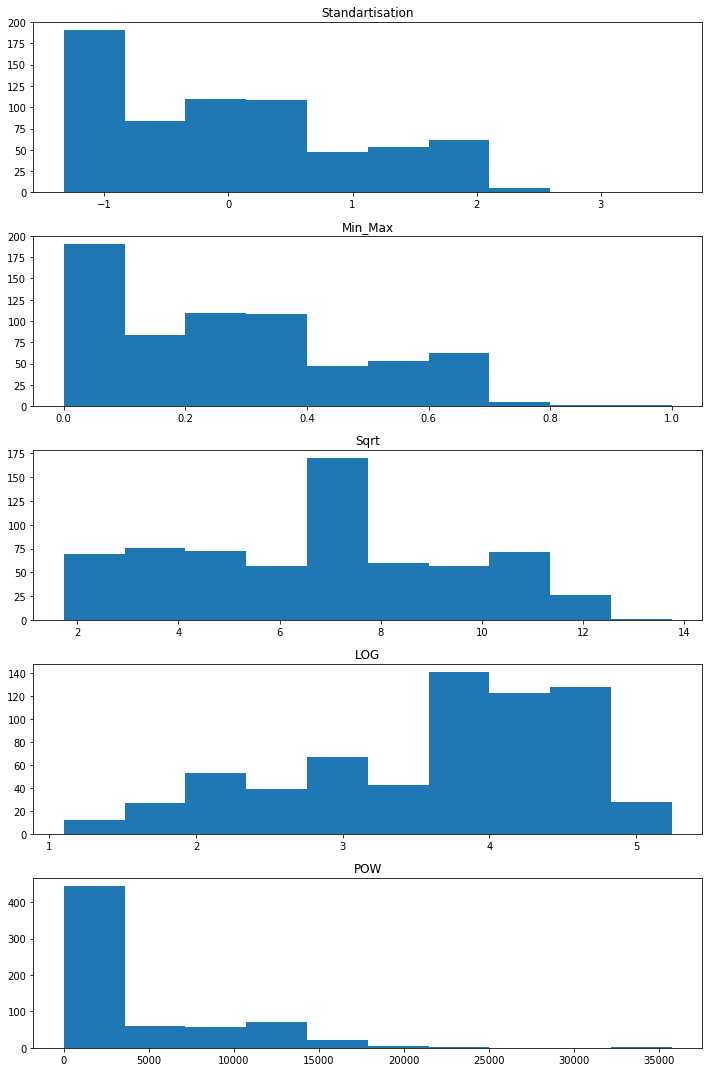

In [60]:
#Applying transformations for AGE
figure, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,15),tight_layout=True,squeeze=False)
data_vector = np.array(new_data['Age']).reshape(-1,1)
data = new_data['Age']

axes[0, 0].hist(StandardScaler().fit(data_vector).transform(data_vector))
axes[0, 0].set_title('Standartisation')

axes[1, 0].hist(MinMaxScaler().fit(data_vector).transform(data_vector))
axes[1, 0].set_title('Min_Max')

sq_data = [math.sqrt(x) for x in data]
axes[2, 0].hist(sq_data)
axes[2, 0].set_title('Sqrt')

log_data = [math.log(x) for x in data]
axes[3, 0].hist(log_data)
axes[3, 0].set_title('LOG')

pow_data = [math.pow(x,2) for x in data]
axes[4, 0].hist(pow_data)
axes[4, 0].set_title('POW')

plt.show()

- For **AGE**, the LOG function looks suitable

### travel_min_to_CBD 

In [61]:
#Applying transformations for Travel time to CBD
figure, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,15),tight_layout=True,squeeze=False)
data_vector = np.array(new_data['travel_min_to_CBD']).reshape(-1,1)
data = new_data['travel_min_to_CBD']

axes[0, 0].hist(StandardScaler().fit(data_vector).transform(data_vector))
axes[0, 0].set_title('Standartisation')

axes[1, 0].hist(MinMaxScaler().fit(data_vector).transform(data_vector))
axes[1, 0].set_title('Min_Max')

sq_data = [math.sqrt(x) for x in data]
axes[2, 0].hist(sq_data)
axes[2, 0].set_title('Sqrt')

#Since there are zero values, we cannot use LOG
# log_data = [math.log(x) for x in data]
# axes[3, 0].hist(log_data)
# axes[3, 0].set_title('LOG')

pow_data = [math.pow(x,2) for x in data]
axes[4, 0].hist(pow_data)
axes[4, 0].set_title('POW')

plt.show()

C:\Users\Raguram R D\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


- For **Travel time to CBD**, the Standariser/MinMax function looks more normal than others

### Final Inference

- Below are the final inferences obtained from the above graphs
- There transformations are applied on the relevant columns and the model is predicted

#### Rooms - Alredy standardized
#### Age - Z-Standardiser function  is used
#### Travel_time_to_CBD - Z-Standardiser/MinMax looks like a good fit
#### Crime_C_Avg - SQRT function

In [63]:
##TRANSFORMATIONS APPLIED ON THE COLUMNS
data_vector = np.array(new_data['Age']).reshape(-1,1)
new_age = StandardScaler().fit(data_vector).transform(data_vector)

#new_age = [math.sqrt(x) for x in new_data['Age']]
new_crime = [math.sqrt(x) for x in new_data['crime_C_average']]

data_vector = np.array(new_data['travel_min_to_CBD']).reshape(-1,1)
travel_time = StandardScaler().fit(data_vector).transform(data_vector)

new_data['New_age'] = new_age
new_data['New_crime'] = new_crime
new_data['travel_time'] = travel_time
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 0 to 683
Data columns (total 8 columns):
Rooms                661 non-null int64
crime_C_average      661 non-null int64
travel_min_to_CBD    661 non-null float64
Age                  661 non-null float64
Price                661 non-null float64
New_age              661 non-null float64
New_crime            661 non-null float64
travel_time          661 non-null float64
dtypes: float64(6), int64(2)
memory usage: 46.5 KB


In [64]:
lm = LinearRegression()
X_data = new_data[['Rooms', 'New_crime', 'travel_time', 'New_age']]
Y_data = new_data['Price']
model = lm.fit(X_data, Y_data)
y_pred = model.predict(X_data)
metrics.r2_score(Y_data,y_pred)

0.37189055796520165

#### Even with reshaping, the accuracy is almost the same. But if we have more datapoints and more features, the reshaping would be the best fit option for improving the accuracy of the model

### REFERENCES

- https://gis.stackexchange.com/questions/226160/pyshp-draws-polygons-out-of-order-after-intersection-of-two-shapefiles
- https://github.com/matplotlib/matplotlib/issues/9704
- https://stackoverflow.com/questions/15968762/shapefile-and-matplotlib-plot-polygon-collection-of-shapefile-coordinates
- https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
